In [1]:
import os
import glob

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim, functional
from torchvision import transforms

from torchvision.utils import make_grid
from torchvision.io import decode_image

from torchvision_plotting import plot as helpers_plot
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchsummary import summary

random.seed(15)

### Import film and digital data

In [2]:
class ImageDataset(Dataset):
    def __init__(self, file_list, apply_transform = None,  film_or_digital = "digial"):
        "Apply transform must be a transform object"

        self.file_paths = file_list
        self.apply_transform = apply_transform
        self.film_or_digital = film_or_digital

    def __len__(self):
        return f"Working with {len(self.file_paths)} files"
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]

        image = Image.open(img_path).convert("RGB")


        #Make sure to align film or digital transformations correctly"
        if self.apply_transform:
            print(f"Transforming {self.film_or_digital} images")
            image = self.apply_transform(image)
        
        return image
    


In [3]:
def dataset_splitting_preparation(data_paths, 
                                split_portions = (.80, .10, .10),
                                transforms_to_apply = None,
                                pic_type = 'digital'):
    full_amnt = len(data_paths)
    
    train_amnt = int(split_portions[0] * full_amnt)
    val_amnt = int(split_portions[1] * full_amnt)
    test_amnt = int(split_portions[2] * full_amnt)

    assert split_portions[0] + split_portions[1] + split_portions[2] == 1.0, "Train, Val, test splits do not sum to 1"
    

    random.shuffle(data_paths)

    train_data = data_paths[:train_amnt]
    val_data = data_paths[train_amnt:val_amnt + train_amnt]
    test_data = data_paths[val_amnt + train_amnt:]

    train_image_data = ImageDataset(file_list = train_data, apply_transform=transforms_to_apply, film_or_digital = pic_type)
    val_image_data = ImageDataset(file_list = val_data, apply_transform=transforms_to_apply, film_or_digital = pic_type)
    test_image_data = ImageDataset(file_list = test_data, apply_transform=transforms_to_apply, film_or_digital = pic_type)


    return train_image_data, val_image_data, test_image_data



In [4]:
#Implementing image transformations to expand images we are using
resize_dims = (256, 256) if "device" != "cpu" else (128, 128)

film_image_transforms = nn.Sequential(
    transforms.v2.Resize(resize_dims), 
    transforms.v2.ToTensor(), 
    transforms.v2.Normalize(mean = [0.485, 0.456, 0.406],  std =[0.229, 0.224, 0.225])
)

#Implementing image transformations to expand images we are using
digital_image_transforms = nn.Sequential(
    transforms.v2.Resize(resize_dims), 
    transforms.v2.RandomHorizontalFlip(p = 0.2),
    transforms.v2.RandomVerticalFlip(p = 0.2), 
    transforms.v2.ToTensor(), 
    transforms.v2.Normalize(mean = [0.485, 0.456, 0.406],  std =[0.229, 0.224, 0.225])
)



/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
film_paths = "/Users/cody_schiffer/Personal_Projects/filmify!/film_photos"
film_paths = glob.glob(film_paths + "/*.jpeg") # Grabbing all the image file names

# _, axes = plt.subplots(4, 4, figsize=(10, 10))
# for ax, img_path in zip(axes.flatten(), film_paths):
#     ax.imshow(Image.open(img_path))
#     ax.axis("off")

digital_paths = "/Users/cody_schiffer/Personal_Projects/filmify!/digital_photos"
digital_paths = glob.glob(digital_paths + "/*.jpeg")

# _, axes = plt.subplots(4, 4, figsize=(10, 10))
# for ax, img_path in zip(axes.flatten(), digital_paths):
#     ax.imshow(Image.open(img_path))
#     ax.axis("off")

#Limit data for cpu testing
if device == "cpu":
    film_paths = film_paths[:50]
    digital_paths = digital_paths[:50]

split_scheme = (.80,.10,.10)

film_train, film_val, film_test = dataset_splitting_preparation(film_paths,
                                                                split_portions = split_scheme,
                                                                transforms_to_apply=film_image_transforms,
                                                                pic_type="film")
digital_train, digital_val, digital_test = dataset_splitting_preparation(digital_paths,
                                                                        split_portions = split_scheme,
                                                                        transforms_to_apply=digital_image_transforms,
                                                                        pic_type="digital")




Film Training data
Transforming film images
Transforming film images
Transforming film images
Transforming film images
Transforming film images
Digital Training Data
Transforming digital images
Transforming digital images
Transforming digital images
Transforming digital images
Transforming digital images


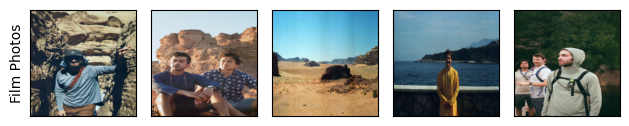

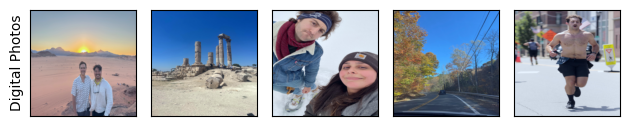

In [6]:
#Show the image transformations
print("Film Training data")
new_images = [film_train[i] for i in range(10, 15)] 
helpers_plot(new_images, row_title = ["Film Photos"])

print("Digital Training Data")
new_images = [digital_train[i] for i in range(10, 15)]
helpers_plot(new_images, row_title = ["Digital Photos"])




In [9]:
#Lets create our dataloaders
if device.type == "cpu":
    batch_size = 1 #should be hyperparameter tuned given normalization strategies
    norm_type = "instance"
else:
    batch_size = 10
    norm_type = "batch"

drop_uneven_batches = True

film_train_DL = DataLoader(film_train, batch_size = batch_size, drop_last = True if drop_uneven_batches else False)
film_val_DL = DataLoader(film_val, batch_size = batch_size, drop_last = False)
film_test_DL = DataLoader(film_test, batch_size=batch_size, drop_last = False)

digital_train_DL = DataLoader(digital_train, batch_size = batch_size, drop_last = True if drop_uneven_batches else False)
digital_val_DL = DataLoader(digital_val, batch_size = batch_size, drop_last = False)
digital_test_DL = DataLoader(digital_test, batch_size = batch_size, drop_last = False)


In [10]:
from modelling import PatchGANDiscriminator, EncoderDecoderSkipConnection
from torch import optim

In [17]:
#Initializing the models
epochs = 10
learning_rate = 0.001

adversarial_loss = nn.BCELoss()
cycle_loss = nn.L1Loss() #Why not use L2Loss()/MSELoss()
identity_loss = nn.L1Loss() #Why not use L2LosS()/MSELoss()

generator = EncoderDecoderSkipConnection(first_channels = 3, res_blocks = 3) #Add standardized output_channel
discriminator = PatchGANDiscriminator(in_channels = 3) #Input channels here must match the output of the decoder above

gen_optimizer = optim.Adam(generator.parameters(), lr = learning_rate)
discr_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate)

generator.to(device)
discriminator.to(device)

print(generator)

print("_______________________")

print(discriminator)


EncoderDecoderSkipConnection(
  (encoder_resblock_decoder): Sequential(
    (0): Encoder(
      (nonlinearity): LeakyReLU(negative_slope=0.01, inplace=True)
      (encoder): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
        (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (1): Sequential(
      (0): ResidualBlock(
        (res_conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (res_batchnorm2d): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (nonlinearity): LeakyReLU(negative_slope=0.01, inplace=True)
        (residual_block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
#Parameter counting 



In [ ]:
#Run the training loop

if device.type == 'cpu':
    epochs = 10
else:
    epochs = 100

cycle_loss_weight = .10
identity_loss_weight = .05

for epoch in range(epochs):
    for pos, (real_digital, real_film) in enumerate(zip(digital_train_DL, film_train_DL)):
        real_digital.to(device)
        real_film.to(device)

        ## Labels for real and fake images 

        #Dynamic method is to forward through the patchgan discriminator and get output shappe
        # Dummy input with the same size as your real images
        expected_shape = real_digital[:1].shape
        dummy_input = torch.randn(real_digital[:1])# (batch_size, channels, height, width)

        # Forward pass to get output shape
        output_shape = discriminator(dummy_input).shape  # (batch_size, 1, height, width)

        # Labels for real and fake images TODO:  # Adjust based on PatchGAN output size
        real_labels = torch.ones(output_shape, device=device) 
        fake_labels = torch.zeros(output_shape, device=device)

        ##Training

        #zero the grads
        gen_optimizer.zero_grad()

        fake_film = generator(real_digital) #digital -> film transformation

        gen_adversarial_loss = adversarial_loss(discriminator(fake_film),  real_labels)

        #Cycle-consistency_loss
        new_digital = generator(fake_film)
        g_cycle_loss = cycle_loss(new_digital, real_digital)


        #Total generator loss
        gen_loss = gen_adversarial_loss + (g_cycle_loss * cycle_loss_weight) + (identity_loss*identity_loss_weight)
        
        gen_loss.backward()
        gen_optimizer.step()

        

        ##Discriminator
        discr_optimizer.zero_grad()

        discr_real_loss = adversarial_loss(discriminator(real_film), real_labels)
        discr_fake_loss = adversarial_loss(discriminator(fake_film.detach()), fake_labels)

        """The discriminator processes the fake (generated) images. 
        The .detach() ensures that gradients from the discriminator's loss 
        do not propagate back to the generator during this step.
        """

        discr_loss = (discr_real_loss + discr_fake_loss) /2 
        discr_loss.backward()
        discr_optimizer.step()

        # ----------------------
        #  Logging
        # ----------------------
        if len(digital_train_DL) > 500:
            progress_report_threshold = 100

        if pos % progress_report_threshold == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {pos}/{len(digital_train_DL)}] "
                  f"[D loss: {discr_loss.item():.4f}] [G loss: {gen_loss.item():.4f}]")
                                       

                        

